# MARATONA BEHIND THE CODE 2020

## DESAFIO 2: PARTE 1

### Introdução

Em projetos de ciência de dados visando a construção de modelos de *machine learning*, ou aprendizado estatístico, é muito incomum que os dados iniciais estejam já no formato ideal para a construção de modelos. São necessários vários passos intermediários de pré-processamento de dados, como por exemplo a codificação de variáveis categóricas, normalização de variáveis numéricas, tratamento de dados faltantes, etc. A biblioteca **scikit-learn** -- uma das mais populares bibliotecas de código-aberto para *machine learning* no mundo -- possui diversas funções já integradas para a realização das transformações de dados mais utilizadas. Entretanto, em um fluxo comum de um modelo de aprendizado de máquina, é necessária a aplicação dessas transformações pelo menos duas vezes: a primeira vez para "treinar" o modelo, e depois novamente quando novos dados forem enviados como entrada para serem classificados por este modelo. 

Para facilitar o trabalho com esse tipo de fluxo, o scikit-learn possui também uma ferramenta chamada **Pipeline**, que nada mais é do que uma lista ordenada de transformações que devem ser aplicadas nos dados. Para auxiliar no desenvolvimento e no gerenciamento de todo o ciclo-de-vida dessas aplicações, alem do uso de Pipelines, as equipes de cientistas de dados podem utilizar em conjunto o **Watson Machine Learning**, que possui dezenas de ferramentas para treinar, gerenciar, hospedar e avaliar modelos baseados em aprendizado de máquina. Além disso, o Watson Machine Learning é capaz de encapsular pipelines e modelos em uma API pronta para uso e integração com outras aplicações.

Durante o desafio 2, você participante irá aprender a construir uma **Pipeline** para um modelo de classificação e hospedá-lo como uma API com o auxílio do Watson Machine Learning. Uma vez hospedado, você poderá integrar o modelo criado com outras aplicações, como assistentes virtuais e muito mais. Neste notebook, será apresentado um exemplo funcional de criação de um modelo e de uma pipeline no scikit-learn (que você poderá utilizar como template para a sua solução!).

### Trabalhando com Pipelines do scikit-learn

In [1]:
# Em seguida iremos importar diversas bibliotecas que serão utilizadas:

# Pacote para trabalhar com JSON
import json

# Pacote para realizar requisições HTTP
import requests

# Pacote para exploração e análise de dados
import pandas as pd

# Pacote com métodos numéricos e representações matriciais
import numpy as np

# Pacote para construção de modelo baseado na técnica Gradient Boosting
import xgboost as xgb

# Pacotes do scikit-learn para pré-processamento de dados
# "SimpleImputer" é uma transformação para preencher valores faltantes em conjuntos de dados
from sklearn.impute import SimpleImputer

# Pacotes do scikit-learn para treinamento de modelos e construção de pipelines
# Método para separação de conjunto de dados em amostras de treino e teste
from sklearn.model_selection import train_test_split
# Método para criação de modelos baseados em árvores de decisão
from sklearn.tree import DecisionTreeClassifier
# Classe para a criação de uma pipeline de machine-learning
from sklearn.pipeline import Pipeline

# Pacotes do scikit-learn para avaliação de modelos
# Métodos para validação cruzada do modelo criado
from sklearn.model_selection import KFold, cross_validate

### Importando um .csv de seu projeto no IBM Cloud Pak for Data para o Kernel deste notebook

Primeiro iremos importar o dataset fornecido para o desafio, que já está incluso neste projeto!

Você pode realizar a importação dos dados de um arquivo .csv diretamente para o Kernel do notebook como um DataFrame da biblioteca Pandas, muito utilizada para a manipulação de dados em Python.

Para realizar a importação, basta selecionar a próxima célula e seguir as instruções na imagem abaixo:

![alt text](https://i.imgur.com/K1DwL9I.png "importing-csv-as-df")

Após a seleção da opção **"Insert to code"**, a célula abaixo será preenchida com o código necessário para importação e leitura dos dados no arquivo .csv como um DataFrame Pandas.

In [2]:
df_data_1 = pd.read_csv('../Data/dataset_desafio_2.csv')


Temos 15 colunas presentes no dataset fornecido, sendo dezessete delas variáveis características (dados de entrada) e um delas uma variável-alvo (que queremos que o nosso modelo seja capaz de prever). 

As variáveis características são:

    MATRICULA       - número de matrícula do estudante
    NOME            - nome completo do estudante
    REPROVACOES_DE  - número de reprovações na disciplina de ``Direito Empresarial``
    REPROVACOES_EM  - número de reprovações na disciplina de ``Empreendedorismo``
    REPROVACOES_MF  - número de reprovações na disciplina de ``Matemática Financeira``
    REPROVACOES_GO  - número de reprovações na disciplina de ``Gestão Operacional``
    NOTA_DE         - média simples das notas do aluno na disciplina de ``Direito Empresarial`` (0-10)
    NOTA_EM         - média simples das notas do aluno na disciplina de ``Empreendedorismo`` (0-10)
    NOTA_MF         - média simples das notas do aluno na disciplina de ``Matemática Financeira`` (0-10)
    NOTA_GO         - média simples das notas do aluno na disciplina de ``Gestão Operacional`` (0-10)
    INGLES          - variável binária que indica se o estudante tem conhecimento em língua inglesa (0 -> sim ou 1 -> não).
    H_AULA_PRES     - horas de estudo presencial realizadas pelo estudante
    TAREFAS_ONLINE  - número de tarefas online entregues pelo estudante
    FALTAS          - número de faltas acumuladas do estudante (todas disciplinas)
    
A variável-alvo é:

    PERFIL               - uma *string* que indica uma de cinco possibilidades: 
        "EXCELENTE"      - Estudante não necessita de mentoria
        "MUITO BOM"      - Estudante não necessita de mentoria
        "HUMANAS"        - Estudante necessita de mentoria exclusivamente em matérias com conteúdo de ciências humanas
        "EXATAS"         - Estudante necessita de mentoria apenas em disciplinas com conteúdo de ciências exatas
        "DIFICULDADE"    - Estudante necessita de mentoria em duas ou mais disciplinas
        
Com um modelo capaz de classificar um estudante em uma dessas categorias, podemos automatizar parte da mentoria estudantil através de assistentes virtuais, que serão capazes de recomendar práticas de estudo e conteúdo personalizado com base nas necessidades de cada aluno.

### Explorando os dados fornecidos

Podemos continuar a exploração dos dados fornecidos com a função ``info()``:

In [3]:
df_data_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   MATRICULA       20000 non-null  int64  
 1   NOME            20000 non-null  object 
 2   REPROVACOES_DE  20000 non-null  int64  
 3   REPROVACOES_EM  20000 non-null  int64  
 4   REPROVACOES_MF  20000 non-null  int64  
 5   REPROVACOES_GO  20000 non-null  int64  
 6   NOTA_DE         20000 non-null  float64
 7   NOTA_EM         20000 non-null  float64
 8   NOTA_MF         20000 non-null  float64
 9   NOTA_GO         16284 non-null  float64
 10  INGLES          16372 non-null  float64
 11  H_AULA_PRES     20000 non-null  int64  
 12  TAREFAS_ONLINE  20000 non-null  int64  
 13  FALTAS          20000 non-null  int64  
 14  PERFIL          20000 non-null  object 
dtypes: float64(5), int64(8), object(2)
memory usage: 2.3+ MB


É notado que existem variáveis do tipo ``float64`` (números "decimais"), variáveis do tipo ``int64`` (números inteiros) e do tipo ``object`` (nesse caso são *strings*, ou texto). 

Como a maioria dos algoritmos de aprendizado estatístico supervisionado só aceita valores numéricos como entrada, é necessário então o pré-processamento das variáveis do tipo "object" antes de usar esse dataset como entrada para o treinamento de um modelo. Também é notado que existem valores faltantes em várias colunas. Esses valores faltantes também devem ser tratados antes de serem construídos modelos com esse conjunto de dados base.

A função ``describe()`` gera várias informações sobre as variáveis numéricas que também podem ser úteis:

In [4]:
df_data_1.describe()

MATRICULA  REPROVACOES_DE  REPROVACOES_EM  REPROVACOES_MF  \
count   20000.000000    20000.000000    20000.000000    20000.000000   
mean   551148.271400        0.242850        0.242850        0.297650   
std    259488.766584        0.615055        0.615055        0.672813   
min    100003.000000        0.000000        0.000000        0.000000   
25%    326554.250000        0.000000        0.000000        0.000000   
50%    550630.000000        0.000000        0.000000        0.000000   
75%    775524.750000        0.000000        0.000000        0.000000   
max    999995.000000        3.000000        3.000000        3.000000   

       REPROVACOES_GO       NOTA_DE       NOTA_EM       NOTA_MF       NOTA_GO  \
count    20000.000000  20000.000000  20000.000000  20000.000000  16284.000000   
mean         0.293350      5.196560      5.080285      4.817630      4.534101   
std          0.661829      2.522545      2.523928      2.734775      2.509209   
min          0.000000      0.000000      0.000000      0.000000      0.000000   
25%          0.000000      5.200000      4.900000      4.700000      4.500000   
50%          0.000000      6.200000      5.900000      5.500000      5.400000   
75%          0.000000      6.700000      6.700000      6.500000      6.200000   
max          3.000000      9.000000      9.400000     11.500000     10.000000   

             INGLES   H_AULA_PRES  TAREFAS_ONLINE        FALTAS  
count  16372.000000  20000.000000    20000.000000  20000.000000  
mean       0.646286      5.102950        3.140300      4.060600  
std        0.478136      4.118422        1.854909      1.674714  
min        0.000000      0.000000        0.000000      1.000000  
25%        0.000000      2.000000        2.000000      3.000000  
50%        1.000000      4.000000        3.000000      4.000000  
75%        1.000000      6.000000        5.000000      6.000000  
max        1.000000     25.000000        7.000000      8.000000

### Visualizações

Para visualizar o dataset fornecido, podemos utilizar as bibliotecas ``matplotlib`` e ``seaborn``:

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

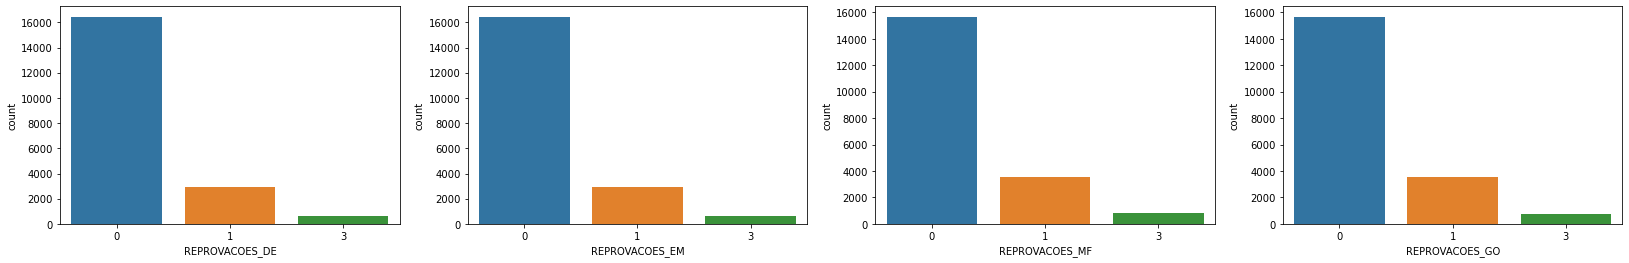

In [6]:
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(28, 4))

sns.countplot(ax=axes[0], x='REPROVACOES_DE', data=df_data_1)
sns.countplot(ax=axes[1], x='REPROVACOES_EM', data=df_data_1)
sns.countplot(ax=axes[2], x='REPROVACOES_MF', data=df_data_1)
sns.countplot(ax=axes[3], x='REPROVACOES_GO', data=df_data_1)

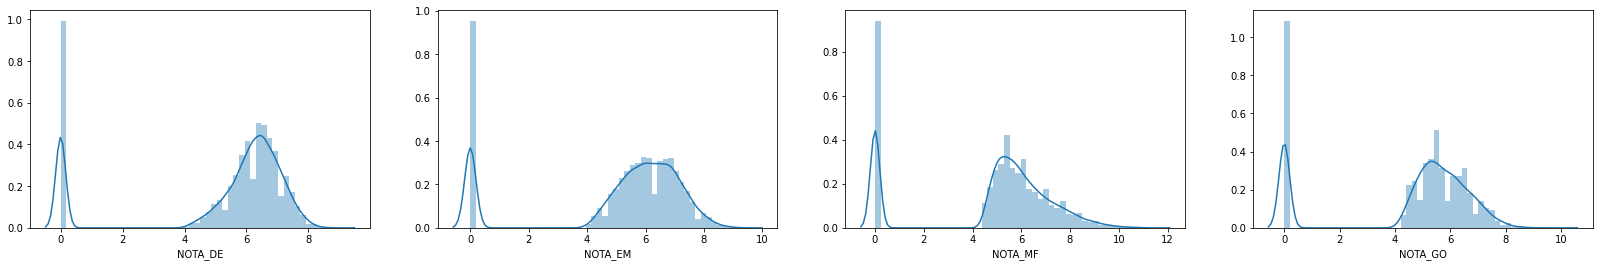

In [7]:
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(28, 4))

sns.distplot(df_data_1['NOTA_DE'], ax=axes[0])
sns.distplot(df_data_1['NOTA_EM'], ax=axes[1])
sns.distplot(df_data_1['NOTA_MF'], ax=axes[2])
sns.distplot(df_data_1['NOTA_GO'].dropna(), ax=axes[3])

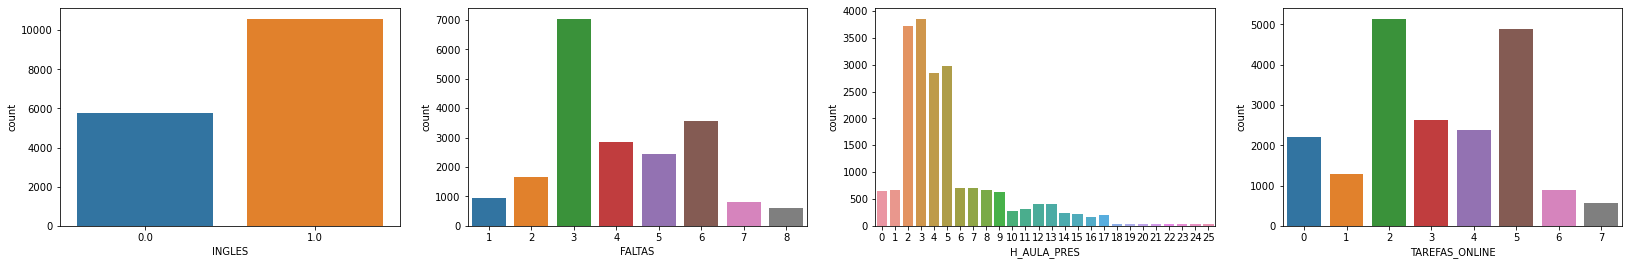

In [8]:
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(28, 4))

sns.countplot(ax=axes[0], x='INGLES', data=df_data_1)
sns.countplot(ax=axes[1], x='FALTAS', data=df_data_1)
sns.countplot(ax=axes[2], x='H_AULA_PRES', data=df_data_1)
sns.countplot(ax=axes[3], x='TAREFAS_ONLINE', data=df_data_1)

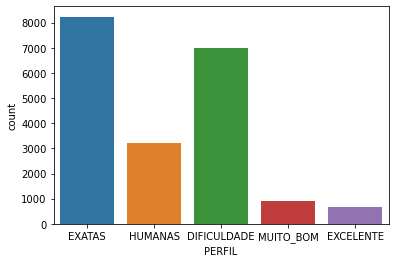

In [9]:
fig = plt.plot()
sns.countplot(x='PERFIL', data=df_data_1)

# Divir em treino e validação


In [10]:
from sklearn.model_selection import StratifiedShuffleSplit


In [11]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

In [12]:
for train_index, val_index in split.split(df_data_1, df_data_1.PERFIL):
    data_train = df_data_1.loc[train_index]    
    data_val = df_data_1.loc[val_index]

In [13]:
print(data_train.shape)
print(data_val.shape)

(16000, 15)
(4000, 15)


In [14]:
data_train.PERFIL.value_counts()

EXATAS         6584
DIFICULDADE    5601
HUMANAS        2557
MUITO_BOM       721
EXCELENTE       537
Name: PERFIL, dtype: int64

Bando de treinamento

In [15]:
100 * data_train.PERFIL.value_counts()/ len(data_train.PERFIL)

EXATAS         41.15000
DIFICULDADE    35.00625
HUMANAS        15.98125
MUITO_BOM       4.50625
EXCELENTE       3.35625
Name: PERFIL, dtype: float64

Bando de validação

In [16]:
100 * data_val.PERFIL.value_counts()/ len(data_val.PERFIL)

EXATAS         41.150
DIFICULDADE    35.000
HUMANAS        15.975
MUITO_BOM       4.525
EXCELENTE       3.350
Name: PERFIL, dtype: float64


Divisão preservando as proporções

## Separando features de target


In [17]:
x_train = data_train.drop(['PERFIL', 'NOME', 'MATRICULA'], axis=1)
x_train.shape

(16000, 12)

In [18]:
y_train = data_train.PERFIL

In [19]:
x_train.head()

REPROVACOES_DE  REPROVACOES_EM  REPROVACOES_MF  REPROVACOES_GO  \
1318                0               0               0               0   
918                 0               0               0               0   
12952               0               0               0               0   
12481               0               0               0               0   
5692                0               0               0               0   

       NOTA_DE  NOTA_EM  NOTA_MF  NOTA_GO  INGLES  H_AULA_PRES  \
1318       7.6      8.2      8.5      NaN     1.0            9   
918        5.7      4.9      4.6      NaN     0.0            2   
12952      6.7      6.7      6.8      5.8     NaN            2   
12481      7.1      7.4      8.1      NaN     0.0            3   
5692       4.6      5.4      5.6      5.0     1.0            4   

       TAREFAS_ONLINE  FALTAS  
1318                6       1  
918                 2       6  
12952               0       4  
12481               5       3  
5692                4       3

## Features Engeneering

Remoção, tratamento e criação de novas features

- colunas novas que informa se o valor de INGLES ou NOTA_GO estavam ausentes

In [20]:
#x_train['missing_ingles'] = 0
#x_train.loc[x_train['INGLES'].isna(), 'missing_ingles' ] = 1

In [21]:
#x_train['missing_go'] = 0
#x_train.loc[x_train['NOTA_GO'].isna(), 'missing_go' ] = 1

- Tratar missing values. Primeira estratégia: colocar o valor zero. Depois colocar a média em NOTA_GO

In [22]:
from sklearn.impute import SimpleImputer


In [23]:
simple_imputer = SimpleImputer(strategy='constant', fill_value=0, add_indicator=True)
simple_imputer_mean = SimpleImputer(strategy='mean', add_indicator=True)

In [24]:
a = pd.DataFrame(simple_imputer.fit_transform(x_train[["INGLES"]]))
a.index = x_train.index

x_train_f = x_train.copy()
x_train_f[["INGLES", "missing_ingles"]] = a
x_train_f.head(10)

REPROVACOES_DE  REPROVACOES_EM  REPROVACOES_MF  REPROVACOES_GO  \
1318                0               0               0               0   
918                 0               0               0               0   
12952               0               0               0               0   
12481               0               0               0               0   
5692                0               0               0               0   
4195                0               0               0               0   
17826               0               0               0               0   
13100               0               0               0               0   
7376                0               0               0               0   
10561               0               0               0               0   

       NOTA_DE  NOTA_EM  NOTA_MF  NOTA_GO  INGLES  H_AULA_PRES  \
1318       7.6      8.2      8.5      NaN     1.0            9   
918        5.7      4.9      4.6      NaN     0.0            2   
12952      6.7      6.7      6.8      5.8     0.0            2   
12481      7.1      7.4      8.1      NaN     0.0            3   
5692       4.6      5.4      5.6      5.0     1.0            4   
4195       7.0      7.2      8.1      NaN     0.0           13   
17826      6.6      4.7      5.3      NaN     0.0            3   
13100      6.7      5.4      6.6      6.9     0.0            8   
7376       5.2      5.2      5.1      4.8     1.0            7   
10561      5.9      5.4      5.3      5.4     1.0            4   

       TAREFAS_ONLINE  FALTAS  missing_ingles  
1318                6       1             0.0  
918                 2       6             0.0  
12952               0       4             1.0  
12481               5       3             0.0  
5692                4       3             0.0  
4195                7       2             0.0  
17826               3       3             0.0  
13100               0       3             0.0  
7376                4       1             0.0  
10561               2       5             0.0

In [25]:
a = pd.DataFrame(simple_imputer_mean.fit_transform(x_train[["NOTA_GO"]]))
a.index = x_train_f.index

x_train_f[["NOTA_GO", "missing_go"]] = a
x_train_f.head(10)


REPROVACOES_DE  REPROVACOES_EM  REPROVACOES_MF  REPROVACOES_GO  \
1318                0               0               0               0   
918                 0               0               0               0   
12952               0               0               0               0   
12481               0               0               0               0   
5692                0               0               0               0   
4195                0               0               0               0   
17826               0               0               0               0   
13100               0               0               0               0   
7376                0               0               0               0   
10561               0               0               0               0   

       NOTA_DE  NOTA_EM  NOTA_MF   NOTA_GO  INGLES  H_AULA_PRES  \
1318       7.6      8.2      8.5  4.531325     1.0            9   
918        5.7      4.9      4.6  4.531325     0.0            2   
12952      6.7      6.7      6.8  5.800000     0.0            2   
12481      7.1      7.4      8.1  4.531325     0.0            3   
5692       4.6      5.4      5.6  5.000000     1.0            4   
4195       7.0      7.2      8.1  4.531325     0.0           13   
17826      6.6      4.7      5.3  4.531325     0.0            3   
13100      6.7      5.4      6.6  6.900000     0.0            8   
7376       5.2      5.2      5.1  4.800000     1.0            7   
10561      5.9      5.4      5.3  5.400000     1.0            4   

       TAREFAS_ONLINE  FALTAS  missing_ingles  missing_go  
1318                6       1             0.0         1.0  
918                 2       6             0.0         1.0  
12952               0       4             1.0         0.0  
12481               5       3             0.0         1.0  
5692                4       3             0.0         0.0  
4195                7       2             0.0         1.0  
17826               3       3             0.0         1.0  
13100               0       3             0.0         0.0  
7376                4       1             0.0         0.0  
10561               2       5             0.0         0.0

In [26]:
x_train.head(10)

REPROVACOES_DE  REPROVACOES_EM  REPROVACOES_MF  REPROVACOES_GO  \
1318                0               0               0               0   
918                 0               0               0               0   
12952               0               0               0               0   
12481               0               0               0               0   
5692                0               0               0               0   
4195                0               0               0               0   
17826               0               0               0               0   
13100               0               0               0               0   
7376                0               0               0               0   
10561               0               0               0               0   

       NOTA_DE  NOTA_EM  NOTA_MF  NOTA_GO  INGLES  H_AULA_PRES  \
1318       7.6      8.2      8.5      NaN     1.0            9   
918        5.7      4.9      4.6      NaN     0.0            2   
12952      6.7      6.7      6.8      5.8     NaN            2   
12481      7.1      7.4      8.1      NaN     0.0            3   
5692       4.6      5.4      5.6      5.0     1.0            4   
4195       7.0      7.2      8.1      NaN     0.0           13   
17826      6.6      4.7      5.3      NaN     0.0            3   
13100      6.7      5.4      6.6      6.9     0.0            8   
7376       5.2      5.2      5.1      4.8     1.0            7   
10561      5.9      5.4      5.3      5.4     1.0            4   

       TAREFAS_ONLINE  FALTAS  
1318                6       1  
918                 2       6  
12952               0       4  
12481               5       3  
5692                4       3  
4195                7       2  
17826               3       3  
13100               0       3  
7376                4       1  
10561               2       5

- Adicionar uma coluna nova para cada nota, informando qual se a amostra tinha a determinada nota zero


In [27]:
x_train_f.loc[x_train_f['NOTA_DE']==0, 'zero_de' ] = 1
x_train_f.loc[x_train_f['NOTA_DE']!=0, 'zero_de' ] = 0

In [28]:
x_train_f.loc[x_train_f['NOTA_EM']==0, 'zero_em' ] = 1
x_train_f.loc[x_train_f['NOTA_EM']!=0, 'zero_em' ] = 0

In [29]:
x_train_f.loc[x_train_f['NOTA_MF']==0, 'zero_mf' ] = 1
x_train_f.loc[x_train_f['NOTA_MF']!=0, 'zero_mf' ] = 0

In [30]:
x_train_f.loc[x_train_f['NOTA_GO']==0, 'zero_go' ] = 1
x_train_f.loc[x_train_f['NOTA_GO']!=0, 'zero_go' ] = 0

In [31]:
x_train_f.head()

REPROVACOES_DE  REPROVACOES_EM  REPROVACOES_MF  REPROVACOES_GO  \
1318                0               0               0               0   
918                 0               0               0               0   
12952               0               0               0               0   
12481               0               0               0               0   
5692                0               0               0               0   

       NOTA_DE  NOTA_EM  NOTA_MF   NOTA_GO  INGLES  H_AULA_PRES  \
1318       7.6      8.2      8.5  4.531325     1.0            9   
918        5.7      4.9      4.6  4.531325     0.0            2   
12952      6.7      6.7      6.8  5.800000     0.0            2   
12481      7.1      7.4      8.1  4.531325     0.0            3   
5692       4.6      5.4      5.6  5.000000     1.0            4   

       TAREFAS_ONLINE  FALTAS  missing_ingles  missing_go  zero_de  zero_em  \
1318                6       1             0.0         1.0      0.0      0.0   
918                 2       6             0.0         1.0      0.0      0.0   
12952               0       4             1.0         0.0      0.0      0.0   
12481               5       3             0.0         1.0      0.0      0.0   
5692                4       3             0.0         0.0      0.0      0.0   

       zero_mf  zero_go  
1318       0.0      0.0  
918        0.0      0.0  
12952      0.0      0.0  
12481      0.0      0.0  
5692       0.0      0.0

In [32]:
x_train_f.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16000 entries, 1318 to 1404
Data columns (total 18 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   REPROVACOES_DE  16000 non-null  int64  
 1   REPROVACOES_EM  16000 non-null  int64  
 2   REPROVACOES_MF  16000 non-null  int64  
 3   REPROVACOES_GO  16000 non-null  int64  
 4   NOTA_DE         16000 non-null  float64
 5   NOTA_EM         16000 non-null  float64
 6   NOTA_MF         16000 non-null  float64
 7   NOTA_GO         16000 non-null  float64
 8   INGLES          16000 non-null  float64
 9   H_AULA_PRES     16000 non-null  int64  
 10  TAREFAS_ONLINE  16000 non-null  int64  
 11  FALTAS          16000 non-null  int64  
 12  missing_ingles  16000 non-null  float64
 13  missing_go      16000 non-null  float64
 14  zero_de         16000 non-null  float64
 15  zero_em         16000 non-null  float64
 16  zero_mf         16000 non-null  float64
 17  zero_go         16000 non-nul

In [33]:
x_train_f.isna().sum()

REPROVACOES_DE    0
REPROVACOES_EM    0
REPROVACOES_MF    0
REPROVACOES_GO    0
NOTA_DE           0
NOTA_EM           0
NOTA_MF           0
NOTA_GO           0
INGLES            0
H_AULA_PRES       0
TAREFAS_ONLINE    0
FALTAS            0
missing_ingles    0
missing_go        0
zero_de           0
zero_em           0
zero_mf           0
zero_go           0
dtype: int64

- Criar uma nova feature  com o somatório das notas das quatro disciplinas

In [34]:
x_train_f['sum_notas' ] = x_train_f.NOTA_DE + x_train_f.NOTA_EM + x_train_f.NOTA_GO + x_train_f.NOTA_MF

- Criar nova feature com o sumatótio de quantas disciplinas o aluno tirou nota zero

In [35]:
x_train_f['sum_zero' ] = x_train_f.zero_de + x_train_f.zero_em + x_train_f.zero_go + x_train_f.zero_mf

- somatorio de reprovações que o aluno contabiliza

In [36]:
x_train_f['sum_reprovacoes' ] = x_train_f.REPROVACOES_DE + x_train_f.REPROVACOES_EM + x_train_f.REPROVACOES_GO + x_train_f.REPROVACOES_MF

In [37]:
x_train_f.tail()

REPROVACOES_DE  REPROVACOES_EM  REPROVACOES_MF  REPROVACOES_GO  \
10973               0               0               0               0   
7560                0               0               0               0   
753                 1               1               1               3   
7449                0               0               0               0   
1404                0               0               0               0   

       NOTA_DE  NOTA_EM  NOTA_MF   NOTA_GO  INGLES  H_AULA_PRES  ...  FALTAS  \
10973      5.8      6.1      5.7  5.600000     1.0            3  ...       5   
7560       6.8      6.6      6.5  4.531325     1.0            5  ...       5   
753        0.0      0.0      0.0  0.000000     1.0            5  ...       1   
7449       6.5      5.6      4.7  5.700000     1.0            4  ...       6   
1404       5.3      4.9      5.0  5.000000     0.0            5  ...       2   

       missing_ingles  missing_go  zero_de  zero_em  zero_mf  zero_go  \
10973             0.0         0.0      0.0      0.0      0.0      0.0   
7560              0.0         1.0      0.0      0.0      0.0      0.0   
753               0.0         0.0      1.0      1.0      1.0      1.0   
7449              0.0         0.0      0.0      0.0      0.0      0.0   
1404              0.0         0.0      0.0      0.0      0.0      0.0   

       sum_notas  sum_zero  sum_reprovacoes  
10973  23.200000       0.0                0  
7560   24.431325       0.0                0  
753     0.000000       4.0                6  
7449   22.500000       0.0                0  
1404   20.200000       0.0                0  

[5 rows x 21 columns]


### Diferentes balanceamentos

- Upscaling

In [38]:
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import RandomUnderSampler

In [39]:
y_train.value_counts()

EXATAS         6584
DIFICULDADE    5601
HUMANAS        2557
MUITO_BOM       721
EXCELENTE       537
Name: PERFIL, dtype: int64

In [40]:
smote = SMOTE(random_state=42, sampling_strategy={'HUMANAS':3000, 'MUITO_BOM':2000,'EXCELENTE':2000})

In [41]:
x_train_f_up, y_train_up = smote.fit_resample(x_train_f, y_train)

In [42]:
y_train_up.value_counts()

EXATAS         6584
DIFICULDADE    5601
HUMANAS        3000
MUITO_BOM      2000
EXCELENTE      2000
Name: PERFIL, dtype: int64

- MIX - Upscaling e dowscalling

In [43]:
underSampling = RandomUnderSampler(sampling_strategy={'EXATAS':4000, 'DIFICULDADE':4000})

In [44]:
x_train_f_under, y_train_under = underSampling.fit_resample(x_train_f, y_train)

In [45]:
y_train_under.value_counts()

DIFICULDADE    4000
EXATAS         4000
HUMANAS        2557
MUITO_BOM       721
EXCELENTE       537
Name: PERFIL, dtype: int64

In [46]:
smoteen = SMOTETomek()

In [47]:
x_train_f_mix, y_train_mix = smoteen.fit_resample(x_train_f_under, y_train_under)

In [48]:
y_train_mix.value_counts()

EXCELENTE      3996
MUITO_BOM      3976
HUMANAS        3902
DIFICULDADE    3596
EXATAS         3544
Name: PERFIL, dtype: int64

- under 2


In [49]:
underSampling = RandomUnderSampler(sampling_strategy={'EXATAS':1200, 'DIFICULDADE':1200, 'HUMANAS':1200})

In [50]:
x_train_f_under2, y_train_under2 = underSampling.fit_resample(x_train_f, y_train)

In [51]:
y_train_under2.value_counts()

EXATAS         1200
HUMANAS        1200
DIFICULDADE    1200
MUITO_BOM       721
EXCELENTE       537
Name: PERFIL, dtype: int64

### scale

In [52]:
from sklearn.preprocessing import StandardScaler

In [53]:
scale = StandardScaler()
    

In [54]:
scale.fit(x_train_f, y_train)

StandardScaler()

# Treinamento

In [55]:
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC

In [56]:
clf = RandomForestClassifier(max_depth=10)
#clf = SVC(C=10)

In [57]:
clf.fit(x_train_f, y_train)

RandomForestClassifier(max_depth=10)

In [58]:
pred_train = clf.predict(x_train_f)

In [59]:
print(classification_report(pred_train, y_train))

              precision    recall  f1-score   support

 DIFICULDADE       0.75      0.93      0.83      4558
      EXATAS       0.94      0.82      0.88      7617
   EXCELENTE       0.74      0.80      0.77       497
     HUMANAS       0.99      0.79      0.88      3179
   MUITO_BOM       0.20      0.95      0.33       149

    accuracy                           0.84     16000
   macro avg       0.72      0.86      0.74     16000
weighted avg       0.89      0.84      0.86     16000



# Validação

Dataset

In [66]:
x_val = data_val.drop(['PERFIL', 'NOME', 'MATRICULA'], axis=1)
y_val = data_val.PERFIL

In [67]:
a = pd.DataFrame(simple_imputer.transform(x_val[["INGLES"]]))
a.index = x_val.index
x_val_f = x_val.copy()
x_val_f[["INGLES", "missing_ingles"]] = a

In [68]:
a = pd.DataFrame(simple_imputer_mean.transform(x_val[["NOTA_GO"]]))
a.index = x_val_f.index
x_val_f[["NOTA_GO", "missing_go"]] = a

In [70]:
x_val_f.loc[x_val_f['NOTA_DE']==0, 'zero_de' ] = 1
x_val_f.loc[x_val_f['NOTA_DE']!=0, 'zero_de' ] = 0

x_val_f.loc[x_val_f['NOTA_EM']==0, 'zero_em' ] = 1
x_val_f.loc[x_val_f['NOTA_EM']!=0, 'zero_em' ] = 0

x_val_f.loc[x_val_f['NOTA_MF']==0, 'zero_mf' ] = 1
x_val_f.loc[x_val_f['NOTA_MF']!=0, 'zero_mf' ] = 0

x_val_f.loc[x_val_f['NOTA_GO']==0, 'zero_go' ] = 1
x_val_f.loc[x_val_f['NOTA_GO']!=0, 'zero_go' ] = 0

x_val_f['sum_notas' ] = x_val_f.NOTA_DE + x_val_f.NOTA_EM + x_val_f.NOTA_GO + x_val_f.NOTA_MF
x_val_f['sum_zero' ] = x_val_f.zero_de + x_val_f.zero_em + x_val_f.zero_go + x_val_f.zero_mf
x_val_f['sum_reprovacoes' ] = x_val_f.REPROVACOES_DE + x_val_f.REPROVACOES_EM + x_val_f.REPROVACOES_GO + x_val_f.REPROVACOES_MF

In [71]:
x_val_f.head()

REPROVACOES_DE  REPROVACOES_EM  REPROVACOES_MF  REPROVACOES_GO  \
15665               0               0               0               0   
4364                0               0               0               0   
19456               0               0               0               0   
11580               0               0               0               0   
751                 0               0               0               0   

       NOTA_DE  NOTA_EM  NOTA_MF   NOTA_GO  INGLES  H_AULA_PRES  ...  FALTAS  \
15665      7.7      8.2      8.4  7.200000     0.0           12  ...       1   
4364       6.2      5.8      5.7  6.300000     0.0            3  ...       3   
19456      6.7      6.8      7.6  6.000000     0.0            5  ...       4   
11580      6.4      6.3      5.5  4.531325     1.0            4  ...       4   
751        6.4      5.9      5.3  5.100000     0.0            2  ...       5   

       missing_ingles  missing_go  zero_de  zero_em  zero_mf  zero_go  \
15665             0.0         0.0      0.0      0.0      0.0      0.0   
4364              0.0         0.0      0.0      0.0      0.0      0.0   
19456             0.0         0.0      0.0      0.0      0.0      0.0   
11580             0.0         1.0      0.0      0.0      0.0      0.0   
751               0.0         0.0      0.0      0.0      0.0      0.0   

       sum_notas  sum_zero  sum_reprovacoes  
15665  31.500000       0.0                0  
4364   24.000000       0.0                0  
19456  27.100000       0.0                0  
11580  22.731325       0.0                0  
751    22.700000       0.0                0  

[5 rows x 21 columns]

### Predição e avaliação 


In [72]:
pred_val = clf.predict(x_val_f)

In [73]:
print(classification_report(y_val, pred_val))

              precision    recall  f1-score   support

 DIFICULDADE       0.92      0.73      0.82      1400
      EXATAS       0.80      0.94      0.87      1646
   EXCELENTE       0.64      0.65      0.64       134
     HUMANAS       0.76      0.96      0.85       639
   MUITO_BOM       0.33      0.03      0.05       181

    accuracy                           0.82      4000
   macro avg       0.69      0.66      0.65      4000
weighted avg       0.81      0.82      0.80      4000



In [74]:
print(accuracy_score(y_val, pred_val))

0.82025


# Insights


## SelectKBest

In [75]:
from sklearn.feature_selection import SelectKBest

In [76]:
for i in range(x_train_f.shape[1], 5, -1):
    skb = SelectKBest(k = i)
    xx = skb.fit_transform(x_train_f, y_train)
    clf.fit(xx, y_train)
    pred = clf.predict(skb.transform(x_val_f))
    print(i, accuracy_score(y_val, pred))

21 0.81875
20 0.81875
19 0.82075
18 0.82175
17 0.82075
16 0.82075
15 0.81975
14 0.82125
13 0.82175
12 0.8205
11 0.8195
10 0.8205
9 0.82125
8 0.82125
7 0.821
6 0.82025


In [ ]:
x_train_f.columns


### Analise


In [78]:
import eli5
from eli5.sklearn import PermutationImportance
# fit model here
#clf = XGBClassifier()
clf.fit(x_train_f, y_train)
model = clf
perm = PermutationImportance(model, random_state=1)
perm.fit(x_train_f, y_train)


PermutationImportance(estimator=RandomForestClassifier(max_depth=10),
                      random_state=1)

In [79]:
# show
features = ['REPROVACOES_DE', 'REPROVACOES_EM', 'REPROVACOES_MF', 'REPROVACOES_GO',
       'NOTA_DE', 'NOTA_EM', 'NOTA_MF', 'NOTA_GO', 'INGLES', 'H_AULA_PRES',
       'TAREFAS_ONLINE', 'FALTAS', 'zero_de', 'zero_em', 'zero_mf', 'zero_go',
       'sum_notas', 'sum_zero', 'sum_reprovacoes', 'missing_ingles', 'missing_go']
eli5.show_weights(perm, feature_names=features)

In [ ]:
type(features)